IMPORT LIBRARIES AND OTHER BASIC STUFF

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel, BertForTokenClassification, BertForSequenceClassification
from transformers import pipeline
from tqdm import tqdm
import torch
import re  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA LOADING AND PRE-PROCESSING

In [53]:

df_alexa = pd.read_csv('/home/iason/Desktop/amazon_alexa.tsv', sep='\t')
ner_test_df = pd.read_csv('/home/iason/Desktop/NER-test.tsv', sep='\t', header=None, names=['sentence_id', 'word_id', 'word', 'label'], usecols=[0, 1, 2, 3])
sentiment_topic_test_df = pd.read_csv('/home/iason/Desktop/sentiment-topic-test.tsv', sep='\t')

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text.strip()
    else:
        return ""


df_alexa['cleaned_review'] = df_alexa['verified_reviews'].apply(clean_text)
ner_test_df['cleaned_review'] = ner_test_df['word'].apply(clean_text)
sentiment_topic_test_df['cleaned_review'] = sentiment_topic_test_df['sentence'].apply(clean_text)
ner_test_df.drop(index=0, inplace=True)
ner_test_df

print("Cleaned Review Dataset:")
print(df_alexa[['verified_reviews', 'cleaned_review']].head())

print("\nCleaned NER Test Set:")
print(ner_test_df[['sentence_id', 'word', 'label']].head())

print("\nCleaned Sentiment Test Set:")
print(sentiment_topic_test_df[['cleaned_review', 'sentiment']].head())




Cleaned Review Dataset:
                                    verified_reviews  \
0                                      Love my Echo!   
1                                          Loved it!   
2  Sometimes while playing a game, you can answer...   
3  I have had a lot of fun with this thing. My 4 ...   
4                                              Music   

                                      cleaned_review  
0                                       love my echo  
1                                           loved it  
2  sometimes while playing a game you can answer ...  
3  i have had a lot of fun with this thing my 4 y...  
4                                              music  

Cleaned NER Test Set:
  sentence_id   word label
1           0      I     O
2           0  would     O
3           0    n't     O
4           0   have     O
5           0   gone     O

Cleaned Sentiment Test Set:
                                      cleaned_review sentiment
0  the atmosphere at the stadium

CHECKING CUDA AND GPU FOR FINE-TUNING MODELS

In [3]:
import torch

# Check if CUDA (NVIDIA GPU) is available
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

# Print the default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")


CUDA is available!
Number of GPUs: 1
Device 0: NVIDIA GeForce GTX 1660 SUPER
Using device: cuda


FINE-TUNE BERT MODEL ON ALEXA REVIEWS DATASET

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

torch.cuda.empty_cache()


df_alexa = df_alexa[["verified_reviews", "feedback"]]
df_alexa = df_alexa.dropna(subset = ['verified_reviews','feedback'])
df_alexa['verified_reviews'] = df_alexa['verified_reviews'].astype(str)
df_alexa['feedback'] = df_alexa["feedback"].astype(str)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_alexa["verified_reviews"], df_alexa["feedback"], test_size=0.2, random_state=42
)
train_texts = [str(text) for text in train_texts]
val_texts = [str(text) for text in val_texts]

float_entries = [i for i, text in enumerate(train_texts) if isinstance(text, float)]
print(float_entries)


train_dict = {"text" : train_texts,"label" : train_labels}

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("dslim/bert-base-NER")

# Tokenization
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_labels = train_labels.astype(int)
val_labels = val_labels.astype(int)

# Load model
model = BertForSequenceClassification.from_pretrained("dslim/bert-base-NER", num_labels=9)
#model.classifier = torch.nn.Linear(model.config.hidden_size, 2)

# Evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    #no_cuda=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Optional: Save the model
model.save_pretrained("alexa-bert-model")
tokenizer.save_pretrained("alexa-bert-model")

CREATE SENTENCES LIST FOR LATER USAGE

In [54]:



ner_test_df['sentence'] = ner_test_df.groupby('sentence_id')['word'].transform(lambda x: ' '.join(x))

# Now drop duplicates to keep only one row per sentence_id
ner_test_df_sentences = ner_test_df[['sentence_id', 'sentence']].drop_duplicates(subset='sentence_id', keep='first')

# Display the resulting sentences
print(ner_test_df_sentences)
sentences = ner_test_df_sentences['sentence'].tolist()

    sentence_id                                           sentence
1             0  I would n't have gone to that Manchester Unite...
20            1  Elena and her family moved to Barcelona last s...
35            2  The concert by Coldplay at Wembley Stadium was...
46            3  Lionel Messi made his debut for Inter Miami an...
62            4  I can't believe how much I cried watching Tita...
76            5  My friend Sarah just finished reading The Catc...
95            6  Maria Sharapova 's final game against Serena W...
111           7  I spotted a Banksy mural whilst walking throug...
124           8  The Harry Potter series will always be my go-t...
136           9  During my trip to Berlin , I visited the Brand...
155          10  I just finished watching Stranger Things , and...
171          11  I started reading 1984 , and George Orwell 's ...
188          12  Barbie and Oppenheimer releasing on the same d...
204          13  I stumbled across a rare edition of To Kill a

DO A BASIC NER TAGGING WITH THE BERT MODEL(NOT THE FINE-TUNED ONE)

In [ ]:

ner_pipe = pipeline("ner", model="dslim/bert-base-NER", grouped_entities=True)

# Apply NER
def apply_hf_ner(text):
    try:
        return ner_pipe(text)
    except:
        return []

ner_results = []
for text in sentences:
    ner_results.append([text,apply_hf_ner(text)])

# Show some results
print(ner_results[1])
df_output = pd.DataFrame(ner_results)
df_output


USING LARGER BERT MODEL FOR BIOS TAGGING NER

In [ ]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification
import pandas as pd

# Load tokenizer and model for NERC
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = BertForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

# Define the labels for the NERC task (BIO format)
labels = model.config.id2label  # Get label mapping

# Apply NERC at the token level
def apply_hf_nerc_token_level(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predictions (logits) and convert them to label IDs
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    
    # Convert prediction IDs to corresponding labels
    predicted_labels = [labels[pred.item()] for pred in predictions[0]]
    
    # Get the tokenized words
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Combine tokens and predicted labels
    token_labels = list(zip(tokens, predicted_labels))
    
    # Filter out special tokens (e.g., [CLS], [SEP])
    token_labels = [(token, label) for token, label in token_labels if token not in ["[CLS]", "[SEP]", "[PAD]"]]
    
    return token_labels

# Apply NERC to each sentence
nerc_results_token_level = []
for text in sentences:
    nerc_results_token_level.append([text, apply_hf_nerc_token_level(text)])

# Show some results
print(nerc_results_token_level[1])

#For each instance in the list where the label is I-PEROSON or B-PERSON, replace it with I-PER or B-PER
for i in range(len(nerc_results_token_level)):
    for j in range(len(nerc_results_token_level[i][1])):
        if nerc_results_token_level[i][1][j][1] == 'I-PEROSON':
            nerc_results_token_level[i][1][j] = (nerc_results_token_level[i][1][j][0], 'I-PER')
        elif nerc_results_token_level[i][1][j][1] == 'B-PERSON':
            nerc_results_token_level[i][1][j] = (nerc_results_token_level[i][1][j][0], 'B-PER')
# Convert results to a DataFrame
df_output_token_level = pd.DataFrame(nerc_results_token_level, columns=['Sentence', 'Token_Label_Pairs'])

# Display the first few rows of the DataFrame
df_output_token_level.head()

#Save results in dataframe in format: Word, Label
df_output_token_level = df_output_token_level.explode('Token_Label_Pairs')
df_output_token_level[['Word', 'Label']] = pd.DataFrame(df_output_token_level['Token_Label_Pairs'].tolist(), index=df_output_token_level.index)
# Drop the original Token_Label_Pairs column
df_output_token_level = df_output_token_level.drop(columns=['Token_Label_Pairs','Sentence'])
# Reset index
df_output_token_level = df_output_token_level.reset_index(drop=True)
# Display the DataFrame
print(df_output_token_level.head(11))
# Save to CSV
df_output_token_level.to_csv("nerc_results_token_level.csv", index=False)

MANUALLY IDENTIFY THE BIOS TAGS(FIGURE OUT WHICH IS BEGGING AND WHICH IS INSIDE)

In [ ]:
from transformers import pipeline

# Load the pre-trained NER model and tokenizer from Hugging Face
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

def process_ner_results(sentence):
    """
    Processes a sentence through the NER pipeline, adjusts subword tokens, and ensures proper tagging.
    
    Args:
        sentence (str): The input sentence to process.
    
    Returns:
        list: A list of adjusted NER results with proper tagging and indices.
    """
    # Get the NER result
    ner_results = ner_pipeline(sentence)

    # Adjust the results to handle subword tokens and proper tagging
    adjusted_results = []
    current_word = ""
    current_entity = None
    current_start = None  # Track the start index of the current word
    current_end = None  # Track the end index of the current word

    for result in ner_results:
        word = result['word']
        entity = result['entity']
        start = result['start']  # Start index of the current token
        end = result['end']  # End index of the current token

        # Handle subword tokens (e.g., '##ssi') and merge them with the previous token
        if word.startswith("##"):
            current_word += word[2:]  # Merge the subword part into the current word
            current_end = end  # Update the end index to the current token's end
        else:
            # If a new word starts, finalize the previous word and its entity
            if current_word:
                adjusted_results.append({
                    'word': current_word,
                    'entity': current_entity,
                    'start': current_start,
                    'end': current_end
                })
            current_word = word  # Start a new word
            current_entity = entity
            current_start = start  # Update the start index
            current_end = end  # Update the end index

    # Append the last processed word if it exists
    if current_word:
        adjusted_results.append({
            'word': current_word,
            'entity': current_entity,
            'start': current_start,
            'end': current_end
        })

    # Post-process adjusted results to handle overlapping entities and standalone cases
    for i in range(len(adjusted_results)):
        curr = adjusted_results[i]

        # Handle overlapping entities
        if i > 0:
            prev = adjusted_results[i - 1]
            # Check if the end of the previous element is +1 the start of the current element
            #print(f"Checking overlap: prev end {prev['end']}, curr start {curr['start']}")
            if prev['end'] + 1 == curr['start']:
                # Check if both are tagged as I-PER, I-ORG, I-LOC, I-MISC, or I-WORK_OF_ART
                if prev['entity'] == "I-PER" and curr['entity'] == "I-PER":
                    prev['entity'] = "B-PER"
                elif prev['entity'] == "I-ORG" and curr['entity'] == "I-ORG":
                    #print(f"Adjusting entity from {curr['entity']} to B-ORG")
                    prev['entity'] = "B-ORG"
                elif prev['entity'] == "I-LOC" and curr['entity'] == "I-LOC":
                    prev['entity'] = "B-LOC"
                elif prev['entity'] == "I-MISC" and curr['entity'] == "I-MISC":
                    prev['entity'] = "B-MISC"
                elif prev['entity'] == "I-WORK_OF_ART" and curr['entity'] == "I-WORK_OF_ART":
                    prev['entity'] = "B-WORK_OF_ART"

        # Handle standalone I-PER, I-ORG, I-LOC, I-MISC, or I-WORK_OF_ART
        if curr['entity'] in ["I-PER", "I-ORG", "I-LOC", "I-MISC", "I-WORK_OF_ART"]:
            # Check if it's the first or last element, or if it's not preceded or followed by the same tag type
            is_standalone = (
                (i == 0 or adjusted_results[i - 1]['entity'].split("-")[-1] != curr['entity'].split("-")[-1]) and
                (i == len(adjusted_results) - 1 or adjusted_results[i + 1]['entity'].split("-")[-1] != curr['entity'].split("-")[-1])
            )
            if is_standalone:
                #print(f"Standalone entity detected: {curr['word']} with entity {curr['entity']}")
                if curr['entity'] == "I-PER":
                    curr['entity'] = "B-PER"
                elif curr['entity'] == "I-ORG":
                    curr['entity'] = "B-ORG"
                elif curr['entity'] == "I-LOC":
                    curr['entity'] = "B-LOC"
                elif curr['entity'] == "I-MISC":
                    curr['entity'] = "B-MISC"
                elif curr['entity'] == "I-WORK_OF_ART":
                    curr['entity'] = "B-WORK_OF_ART"

    return adjusted_results


# Process each sentence
for sentence in sentences:
    print(f"Sentence: {sentence}")
    results = process_ner_results(sentence)
    print("Adjusted Results:")
    print(results)
    print()

In [ ]:
import pandas as pd

# Load the NER test dataset
ner_test_df = pd.read_csv('/home/iason/Desktop/NER-test.tsv', sep='\t')

# Replace 'I-PERSON' with 'I-PER' and 'B-PERSON' with 'B-PER' in the BIO_NER_tag column
ner_test_df['BIO_NER_tag'] = ner_test_df['BIO_NER_tag'].replace({'I-PERSON': 'I-PER', 'B-PERSON': 'B-PER'})

# Function to process a sentence and get predictions
def process_sentence(sentence_tokens):
    """
    Processes a list of tokens through the NER pipeline and returns predictions.
    
    Args:
        sentence_tokens (list): List of tokens in a sentence.
    
    Returns:
        list: A list of predictions with tokens and their predicted tags.
    """
    sentence = " ".join(sentence_tokens)  # Combine tokens into a sentence
    ner_results = process_ner_results(sentence)  # Use the existing function to process the sentence

    # Align predictions with tokens
    predictions = []
    for token in sentence_tokens:
        # Find the corresponding prediction for the token
        predicted_tag = "O"  # Default to "O" if no match is found
        for result in ner_results:
            if result['word'] == token:
                predicted_tag = result['entity']
                break
        predictions.append(predicted_tag)
    return predictions

# Process the dataset
processed_data = []
for sentence_id, group in ner_test_df.groupby('sentence_id'):
    tokens = group['token'].tolist()
    true_tags = group['BIO_NER_tag'].tolist()

    # Get model predictions
    predicted_tags = process_sentence(tokens)

    # Align predictions with true tags and prepare the comparison data
    for token, true_tag, predicted_tag in zip(tokens, true_tags, predicted_tags):
        is_correct = true_tag == predicted_tag
        processed_data.append({
            'sentence_id': sentence_id,
            'token': token,
            'true_tag': true_tag,
            'predicted_tag': predicted_tag,
            'is_correct': is_correct
        })

# Create a DataFrame with the processed data
comparison_df = pd.DataFrame(processed_data)

# Save the processed data to a new file
comparison_df.to_csv('/home/iason/Desktop/NER-comparison-results.tsv', sep='\t', index=False)

# Display the first few rows of the DataFrame
print(comparison_df.head(20))

#Print the count of True and False predictions
true_count = comparison_df['is_correct'].sum()
false_count = len(comparison_df) - true_count
print(f"Number of True predictions: {true_count}")
print(f"Number of False predictions: {false_count}")
# Calculate the accuracy
accuracy = true_count / len(comparison_df)

print(f"Accuracy: {accuracy:.2f}")
# Print the classification report
from sklearn.metrics import classification_report
# Extract true and predicted labels
true_labels = comparison_df['true_tag'].tolist()
predicted_labels = comparison_df['predicted_tag'].tolist()
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)
# Print the classification report
print("Classification Report:")
print(report)

#Calculate precision, recall, and F1-score and accuracy
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
accuracy = report['accuracy']
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")
print(f"Accuracy: {accuracy:.2f}")


#Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(report.keys()))
# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(report.keys()))
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

TRAINING NAIVE BAYES FOR SENTIMENT ANALYSIS

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load the Train Dataset
train_file_path = '/home/iason/Desktop/train.csv'  # Replace with your actual file path
train_df = pd.read_csv(train_file_path, encoding='ISO-8859-1')

# Step 2: Clean the 'text' column by removing non-string values (e.g., NaN)
train_df = train_df[train_df['text'].apply(lambda x: isinstance(x, str))]

# Step 3: Preprocess the 'text' column (convert to lowercase and clean)
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))

# Step 4: Map the sentiment labels to the target variable (negative, neutral, positive)
train_df['sentiment'] = train_df['sentiment'].map({'negative': 'negative', 'neutral': 'neutral', 'positive': 'positive'})

# Step 5: Check the class distribution
print(train_df['sentiment'].value_counts())

# Step 6: Split the data into training and testing sets
X = train_df['text']
y = train_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Convert the text data to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 8: Train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Step 9: Predict and evaluate the model
y_pred = nb_model.predict(X_test_tfidf)

# Step 10: Print evaluation metrics, ensuring the labels parameter is set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive'], labels=['negative', 'neutral', 'positive'])

# Display results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64
Accuracy: 0.633672974284328
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.44      0.56      2356
     neutral       0.55      0.80      0.65      3343
    positive       0.75      0.59      0.66      2545

    accuracy                           0.63      8244
   macro avg       0.69      0.61      0.62      8244
weighted avg       0.67      0.63      0.63      8244



TRY TRAINING NAIVE BAYES WITH DYNASENT DATASET

In [ ]:

#Naive with Dynasent

import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Step 1: Load the JSONL file
file_path = '/home/iason/Desktop/dynasent-v1.1-round01-yelp-train.jsonl'  # Adjust the path accordingly
with open(file_path, 'r') as file:
    dataset = [json.loads(line) for line in file]

# Step 2: Convert the loaded dataset into a DataFrame
df = pd.DataFrame(dataset)

# Step 3: Extract sentences and their corresponding gold labels
df['sentence'] = df['sentence']
df['gold_label'] = df['gold_label']

# Step 4: Remove rows with missing or invalid labels
df = df[df['gold_label'].notna()]  # Remove rows where gold_label is None or NaN
df = df[df['gold_label'].isin(['positive', 'negative', 'neutral'])]  # Keep only valid labels

# Step 5: Preprocess the sentences (convert to lowercase and clean)
df['cleaned_sentence'] = df['sentence'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))

# Step 6: Convert sentences into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df['cleaned_sentence'])

# Step 7: Define the labels (gold labels)
y = df['gold_label']

# Step 8: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 10: Evaluate the model
accuracy = nb_model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Optional: To make predictions on new data
# new_sentences = ["Your new sentence here"]
# new_sentences_tfidf = tfidf.transform(new_sentences)
# predictions = nb_model.predict(new_sentences_tfidf)
# print(predictions)

NAIVE BAYES TRAINED ON AMAZON ALEXA DATASET

In [ ]:

#Naive with Amazon Alexa

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Step 1: Load the TSV file
file_path = '/home/iason/Desktop/amazon_alexa.tsv'  # Adjust the path accordingly
df = pd.read_csv(file_path, sep='\t')

# Step 2: Inspect the first few rows to understand the structure
print(df.head())

# Step 3: Map the rating to sentiment categories
def map_sentiment(rating):
    if rating <= 2:  # Rating 0, 1, 2 -> Negative
        return 'negative'
    elif rating == 3:  # Rating 3 -> Neutral
        return 'neutral'
    else:  # Rating 4, 5 -> Positive
        return 'positive'

# Apply the mapping to create a 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Step 4: Preprocess the sentences (convert to lowercase and clean)
df['cleaned_sentence'] = df['verified_reviews'].apply(lambda x: ' '.join([word.lower() for word in str(x).split()]))

# Step 5: Convert sentences into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df['cleaned_sentence'])

# Step 6: Define the labels (sentiment categories)
y = df['sentiment']

# Step 7: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 9: Evaluate the model
accuracy = nb_model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Optional: To make predictions on new data
# new_sentences = ["Your new sentence here"]
# new_sentences_tfidf = tfidf.transform(new_sentences)
# predictions = nb_model.predict(new_sentences_tfidf)
# print(predictions)


ALL PRODUCT REVIEWS DATASET TRAINING FOR NAIVE BAYES

In [41]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Step 1: Load the CSV file
file_path = '/home/iason/Desktop/AllProductReviews.csv'  # Path to the file
df = pd.read_csv(file_path)

# Step 2: Map the rating to sentiment categories
def map_sentiment(rating):
    if rating <= 2:  # Rating 1, 2 -> Negative
        return 'negative'
    elif rating == 3:  # Rating 3 -> Neutral
        return 'neutral'
    else:  # Rating 4, 5 -> Positive
        return 'positive'

# Apply the mapping to create a 'sentiment' column
df['sentiment'] = df['ReviewStar'].apply(map_sentiment)

# Step 3: Preprocess the ReviewBody (convert to lowercase and clean)
df['cleaned_review'] = df['ReviewBody'].apply(lambda x: ' '.join([word.lower() for word in str(x).split()]))

# Step 4: Convert reviews into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df['cleaned_review'])

# Step 5: Define the labels (sentiment categories)
y = df['sentiment']

# Step 6: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 8: Evaluate the model
accuracy = nb_model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Optional: To make predictions on new data
# new_reviews = ["Your new review here"]
# new_reviews_tfidf = tfidf.transform(new_reviews)
# predictions = nb_model.predict(new_reviews_tfidf)
# print(predictions)


Accuracy: 75.21%


STARTING MODEL EVALUATION FOR SENTIMENT ANALYSIS NAIVE BAYES

In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load the test dataset
test_file_path = 'sentiment-topic-test.tsv'  # Replace with your actual file path
test_df = pd.read_csv(test_file_path, sep='\t')

# Step 1: Preprocess the 'sentence' column (convert to lowercase and clean)
test_df['cleaned_sentence'] = test_df['sentence'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))

# Step 2: Convert the cleaned text data to TF-IDF features using the same vectorizer used for training
# (Assuming the vectorizer 'tfidf' was already fit on the training data)
X_test_tfidf = tfidf.transform(test_df['cleaned_sentence'])

# Step 3: Predict the sentiment using the trained Naive Bayes model
y_pred_test = nb_model.predict(X_test_tfidf)

# Step 4: Compare the predictions with the true sentiment labels
test_df['predicted_sentiment'] = y_pred_test

# Step 5: Add a new column to compare predicted and true sentiment
test_df['comparison'] = test_df['sentiment'] == test_df['predicted_sentiment']

# Step 6: Display the results (true vs predicted sentiment, and comparison column)
comparison_df = test_df[['sentence_id', 'sentence', 'sentiment', 'predicted_sentiment', 'comparison']]
print(comparison_df.head(10))  # Display the first 10 rows of the comparison DataFrame

   sentence_id                                           sentence sentiment  \
0            0  The atmosphere at the stadium tonight was elec...  positive   
1            1  The game was so intense I forgot to breathe at...  positive   
2            2           It had me hooked from the first chapter.  positive   
3            3  It’s more of a slow burn than a page-turner, b...   neutral   
4            4  It’s split into two timelines, which keeps it ...   neutral   
5            5  I could watch this film a hundred times and st...  positive   
6            6  Best thriller I’ve seen in ages. Had me on the...  positive   
7            7  How do you concede three goals in ten minutes?...  negative   
8            8  They rotated their squad for the cup game, whi...   neutral   
9            9  The trailer gave away most of the plot, but th...   neutral   

  predicted_sentiment  comparison  
0            positive        True  
1            positive        True  
2            positive 

Number of sentences with correct predictions: 7


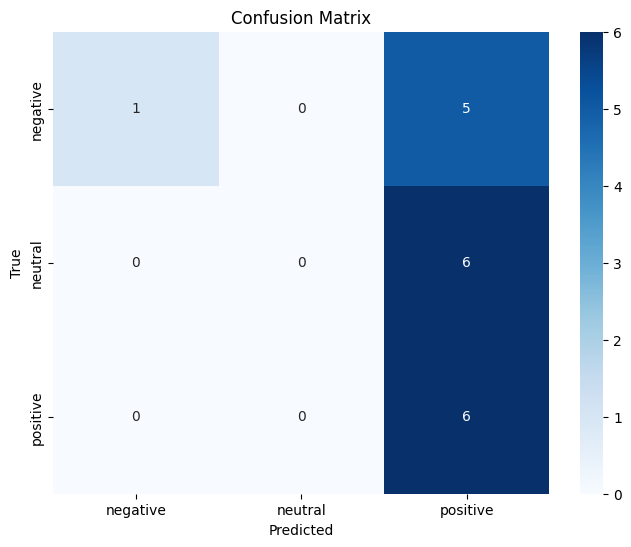

Precision: 0.4509803921568627
Recall: 0.3888888888888889
F1 Score: 0.2691511387163561
Accuracy: 0.3888888888888889


/home/iason/Desktop/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
print(f"Number of sentences with correct predictions: {comparison_df['comparison'].sum()}")

#Compute True Positive, True Negative, False Positive, False Negative
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Compute confusion matrix
cm = confusion_matrix(test_df['sentiment'], test_df['predicted_sentiment'], labels=['negative', 'neutral', 'positive'])
# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['negative', 'neutral', 'positive'], columns=['negative', 'neutral', 'positive'])
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Print precision, accuracy,recall and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
# Calculate precision, recall, and F1 score
precision = precision_score(test_df['sentiment'], test_df['predicted_sentiment'], average='weighted', labels=['negative', 'neutral', 'positive'])
recall = recall_score(test_df['sentiment'], test_df['predicted_sentiment'], average='weighted', labels=['negative', 'neutral', 'positive'])
f1 = f1_score(test_df['sentiment'], test_df['predicted_sentiment'], average='weighted', labels=['negative', 'neutral', 'positive'])
accuracy = accuracy_score(test_df['sentiment'], test_df['predicted_sentiment'])
# Print the metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


SENTIMENT ANALYSIS WITH BERT MODEL

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


    sentence_id                                           sentence sentiment  \
0             0  The atmosphere at the stadium tonight was elec...  positive   
1             1  The game was so intense I forgot to breathe at...  positive   
2             2           It had me hooked from the first chapter.  positive   
3             3  It’s more of a slow burn than a page-turner, b...   neutral   
4             4  It’s split into two timelines, which keeps it ...   neutral   
5             5  I could watch this film a hundred times and st...  positive   
6             6  Best thriller I’ve seen in ages. Had me on the...  positive   
7             7  How do you concede three goals in ten minutes?...  negative   
8             8  They rotated their squad for the cup game, whi...   neutral   
9             9  The trailer gave away most of the plot, but th...   neutral   
10           10  The protagonist was so whiny I wanted to throw...  negative   
11           11  The author’s writing st

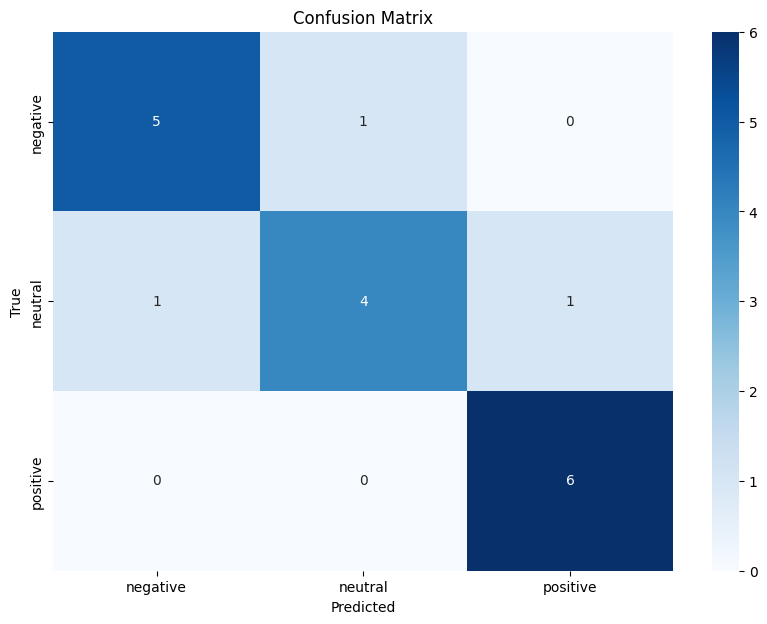

Accuracy: 0.8333
Precision: 0.8302
Recall: 0.8333
F1 Score: 0.8279


In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load 3-class sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)

# Define label map from model config
labels = ['negative', 'neutral', 'positive']

def extract_3way_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return labels[predicted_class]

# Apply to your cleaned review text
#df = pd.read_csv('/home/iason/Desktop/amazon_alexa.tsv', sep='\t')
#df['cleaned_review'] = df['verified_reviews'].apply(clean_text)

#df['sentiment'] = df['cleaned_review'].apply(extract_3way_sentiment)
sentiment_topic_test_df['sentiment_GROUP'] = sentiment_topic_test_df['cleaned_review'].apply(extract_3way_sentiment)

# Example output

#Compare the results with the original sentiment labels
sentiment_topic_test_df['sentiment'] = sentiment_topic_test_df['sentiment'].astype(str)
sentiment_topic_test_df['sentiment_GROUP'] = sentiment_topic_test_df['sentiment_GROUP'].astype(str)
#sentiment_topic_test_df['sentiment'] = sentiment_topic_test_df['sentiment'].astype(str)


#Add a column that says if we got the correct sentiment
sentiment_topic_test_df['correct'] = sentiment_topic_test_df['sentiment'] == sentiment_topic_test_df['sentiment_GROUP']
sentiment_topic_test_df

#Now calculate False Pasitive, False Negative, True Positive, True Negative Accuracy and F1 score and Precision
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd




# Calculate the confusion matrix
conf_matrix = confusion_matrix(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'])
# Calculate accuracy
accuracy = accuracy_score(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'])
# Calculate precision
precision = precision_score(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'], average='weighted')
# Calculate recall
recall = recall_score(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'], average='weighted')
# Calculate F1 score
f1 = f1_score(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'], average='weighted')
# Print the classification report
print("Classification Report:")
print(classification_report(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP']))
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Print the accuracy, precision, recall, and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
# Print the F1 score
print(f"F1 Score: {f1:.4f}")



TOPIC ANALYSIS USING ZERO-SHOT-CLASSIFICATION

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Topic Classification Report:
              precision    recall  f1-score   support

        book       1.00      0.67      0.80         6
       movie       0.75      1.00      0.86         6
      sports       1.00      1.00      1.00         6

    accuracy                           0.89        18
   macro avg       0.92      0.89      0.89        18
weighted avg       0.92      0.89      0.89        18

Topic Confusion Matrix:
[[4 2 0]
 [0 6 0]
 [0 0 6]]


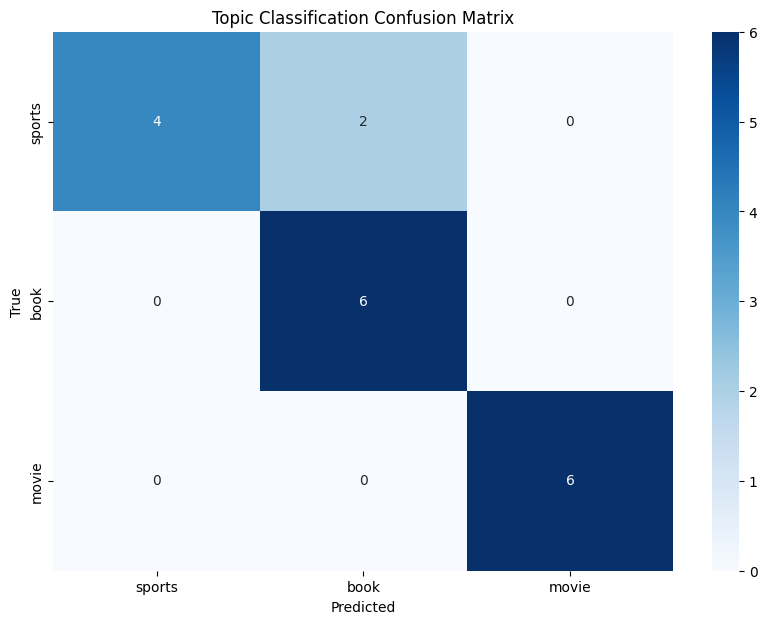

Topic Classification Accuracy: 0.8889
Topic Classification Precision: 0.9167
Topic Classification Recall: 0.8889
Topic Classification F1 Score: 0.8857


In [24]:
from transformers import pipeline
import pandas as pd

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# Load your dataframe (assuming it's already loaded as sentiment_topic_test_df)
df = sentiment_topic_test_df

# List of candidate topics (single words in this case)
candidate_topics = ['sports', 'book', 'movie']

# Function to predict topic for each sentence
def extract_predicted_topic(text):
    result = classifier(text, candidate_labels=candidate_topics)
    # Extract the most likely topic (the one with the highest score)
    predicted_topic = result['labels'][0]  # The first label is the most likely topic
    return predicted_topic

# Apply the function to the 'cleaned_review' column to extract topics
df['predicted_topic'] = df['cleaned_review'].apply(extract_predicted_topic)

# Show the results
df.head()

# Example output - compare predicted topics with true topics if available
# Assuming 'topic' column holds true topic labels
df['topic'] = df['topic'].astype(str)  # Assuming 'topic' is the true label column
df['predicted_topic'] = df['predicted_topic'].astype(str)

# Add a column to check if we got the correct topic prediction
df['correct_topic'] = df['topic'] == df['predicted_topic']

# Now calculate metrics for topic classification
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

conf_matrix_topic = confusion_matrix(df['topic'], df['predicted_topic'])
accuracy_topic = accuracy_score(df['topic'], df['predicted_topic'])
precision_topic = precision_score(df['topic'], df['predicted_topic'], average='weighted')
recall_topic = recall_score(df['topic'], df['predicted_topic'], average='weighted')
f1_topic = f1_score(df['topic'], df['predicted_topic'], average='weighted')

# Print the classification report for topics
print("Topic Classification Report:")
print(classification_report(df['topic'], df['predicted_topic']))

# Print the confusion matrix for topics
print("Topic Confusion Matrix:")
print(conf_matrix_topic)

# Plot the confusion matrix for topics
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_topic, annot=True, fmt='d', cmap='Blues', xticklabels=candidate_topics, yticklabels=candidate_topics)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Topic Classification Confusion Matrix')
plt.show()

# Print the accuracy, precision, recall, and F1 score for topics
print(f"Topic Classification Accuracy: {accuracy_topic:.4f}")
print(f"Topic Classification Precision: {precision_topic:.4f}")
print(f"Topic Classification Recall: {recall_topic:.4f}")
print(f"Topic Classification F1 Score: {f1_topic:.4f}")
